# Plot Embeddings

In [7]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib qt
import matplotlib.pyplot as plt
import plotly.express as px
import itertools

In [8]:
## globals args
data_root_dir = os.getcwd() + '/plots_vae/'
vae_model = 'optimal-laggy-80-filled-s20-2'

agent_models = [
               'optimal',
               'laggy'
               ]

In [27]:
## load embeddings
embeddings = []
embeddings_sep = []
labels = []
label_counts = []

for idx, agent in enumerate(agent_models):
    embedding_dir = data_root_dir + vae_model + '/' + agent + '/'
    embed = np.load(embedding_dir + 'embeddings-trainmixed.npy')
    labels.append([idx] * len(embed))
    label_counts.append(len(embed))
    embeddings.append(embed)
    # embeddings_sep.append((embed - embed.mean(0, keepdims=True)) / embed.std(axis=0))
    embeddings_sep.append(embed / np.linalg.norm(embed, 2))

embeddings = np.concatenate(embeddings)
embeddings = (embeddings - embeddings.mean(0, keepdims=True)) / embeddings.std(axis=0)
labels = list(itertools.chain(*labels))
agent_dict = {0: "optimal", 1:"laggy"} 
models = list(map(agent_dict.get, labels))

In [28]:
# pca = PCA(n_components=3)
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeddings)

## draw PCA using matplotlib
# ax= plt.figure().add_subplot(projection='3d')
# # ax= plt.figure().add_subplot()

# ax.scatter(reduced_embeds[:,0],
#             reduced_embeds[:,1],
#             reduced_embeds[:,2],
#             c = colors)

# plt.show()

In [29]:
## draw PCA using plotly

df_pca = pd.DataFrame(embeds_pca, columns=['pca_1', 'pca_2'])
# df_pca = pd.DataFrame(embeds_pca, columns=['pca_1', 'pca_2', 'pca_3'])
df_pca['agent_model'] = models


# fig = px.scatter_matrix(df_pca,
#                         labels=labels,
#                         dimensions=['pca_1', 'pca_2', 'pca_3'],
#                         color='agent_model')
# fig.update_traces(diagonal_visible=False)

# fig = px.scatter_3d(df_pca,
#                     x='pca_1', y='pca_2', z='pca_3',
#                     color='agent_model')

fig = px.scatter(df_pca, 
                 x="pca_1", y="pca_2",
                #  color_discrete_sequence=["#14213D", "#FCA311", "#976391"],
                 color="agent_model",
                 title='PCA of embeddings -- train data',)
fig.update_layout(margin=dict(l=25, r=25, t=25, b=25),
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  title_x=0.5)

fig.show()

In [8]:
## similarity matrix

sim_matrix = np.zeros([len(agent_models), len(agent_models)])
for l1 in range(len(agent_models)):
    for l2 in range(len(agent_models)):
        if l1 != l2:
            sim_matrix[l1, l2] = cosine_similarity(embeddings_sep[l1], embeddings_sep[l2]).mean()
        else:
            mask = np.ones([len(embeddings_sep[l1]),len(embeddings_sep[l2])], dtype=bool)
            np.fill_diagonal(mask, 0)
            sim_matrix[l1, l2] = (cosine_similarity(embeddings_sep[l1], embeddings_sep[l2])*mask).mean()

## plot similarity matrix
fig = px.imshow(sim_matrix,
                labels=dict(x="agent type", y="agent type", color="similarity"),
                x=['optimal', 'laggy'],
                y=['optimal', 'laggy'],
                text_auto=True
               )
fig.update_xaxes(side="top")
fig.show()

In [21]:
color_dict = {0:'#14213D', 1:'#FCA311', 2:'#976391'}
# 0: 14213D
# 1: FCA311
# 2: 976391
colors = list(map(color_dict.get, labels))

# tsne = TSNE(3, verbose=1)
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(embeddings)

# ax = plt.figure().add_subplot(projection='3d')
ax = plt.figure().add_subplot()
plt.scatter(tsne_proj[:,0],
            tsne_proj[:,1],
            # tsne_proj[:,2],
            color=colors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.000s...
[t-SNE] Computed neighbors for 192 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 6.709093
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.422657
[t-SNE] KL divergence after 1000 iterations: 0.825109


# Plot Trajectory

In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt

import skvideo.io
import cv2

In [99]:
## load data
data_root_dir = os.getcwd() + '/data_videos/'
agent = 'optimal'

root_dir = data_root_dir + agent + '-test/'
file = f'final-model-ppo-LunarLander-v2-{agent}-1.mp4'
frames = skvideo.io.vread(root_dir + file)
truth_data = np.load(root_dir+'env_grids.npy')[1]
agent_poss = np.stack(np.load(root_dir+'agent_poss.npz')['arr_1'])

In [100]:
## plot agent poss
SCALE = 30
agent_poss[...,1] = 400-agent_poss[...,1]*SCALE
agent_poss[...,0] = agent_poss[...,0]*SCALE
agent_poss = agent_poss.astype(int)

In [89]:
agent_poss_img = np.zeros_like(truth_data, float)
for t, poss in enumerate(agent_poss):
    circle = cv2.circle(agent_poss_img, center=poss, 
                        radius=6, color=(128/255, 102/255, 230/255),
                        thickness=-1)
traj_image = agent_poss_img + truth_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


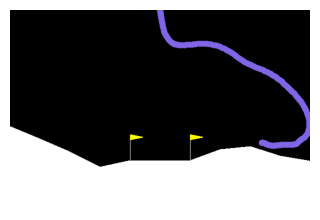

In [90]:
## save trace image
fig = plt.figure(frameon=False)
fig.set_size_inches(3,2)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(traj_image, aspect='auto')
fig.savefig('agent_traj_'+agent+'.png')

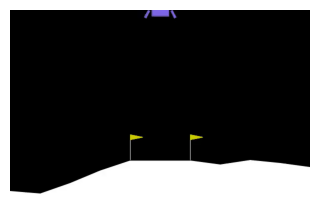

In [103]:
## save trace image
fig = plt.figure(frameon=False)
fig.set_size_inches(3,2)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(frames[0], aspect='auto')
fig.savefig('frame_'+agent+'_0.png')

# Plot SRs

In [45]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import Counter

In [46]:
model = "optimal-laggy-downstream-1"
sr_file = 'sr.pkl'
sr_val_file = 'sr-test.pkl'
truth_file = 'truth.pkl'
truth_val_file = 'truth-test.pkl'
pred_file = 'predictions.pkl'
pred_val_file = 'predictions-test.pkl'

with open('saved_downstream/'+model+'/'+sr_file, 'rb') as f:
    srs = pickle.load(f)

with open('saved_downstream/'+model+'/'+sr_val_file, 'rb') as f:
    srs_val = pickle.load(f)

with open('saved_downstream/'+model+'/'+pred_file, 'rb') as f:
    preds = pickle.load(f)

with open('saved_downstream/'+model+'/'+pred_val_file, 'rb') as f:
    preds_val = pickle.load(f)

with open('saved_downstream/'+model+'/'+truth_file, 'rb') as f:
    truths = pickle.load(f)

with open('saved_downstream/'+model+'/'+truth_val_file, 'rb') as f:
    truths_val = pickle.load(f)

In [47]:
epoch_interest = 979
epoch_interest_val = epoch_interest
sr_interest = srs[epoch_interest]
sr_val_interest = srs_val[epoch_interest_val]

In [48]:
## load SRs
target_sr, pred_sr = zip(*sr_interest)
target_sr = np.concatenate(target_sr)
pred_sr = np.concatenate(pred_sr)
print('train size:', len(target_sr), len(pred_sr))

target_val_sr, pred_val_sr = zip(*sr_val_interest)
target_val_sr = np.concatenate(target_val_sr)
pred_val_sr = np.concatenate(pred_val_sr)
print('val size:', len(target_val_sr), len(pred_val_sr))

train size: 192 192
val size: 113 113


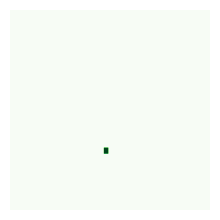

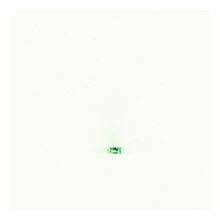

In [124]:
## save SRs on train set
i = 18
gamma = 2
w,h = 2,2
type = 'short'
idx = 1
save = False

## ground truth
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(target_sr[i][gamma].transpose(), aspect='auto', cmap='Greens')
if save:
    fig.savefig(f'SR_truth_{type}_{idx}_gamma{gamma}_train.png')

## pred
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(pred_sr[i][gamma].transpose(), aspect='auto', cmap='Greens')
if save:
    fig.savefig(f'SR_pred_{type}_{idx}_gamma{gamma}_train.png')

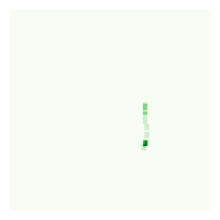

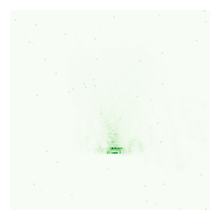

In [203]:
## save SRs on val set
i = 104
gamma = 2
w,h = 2,2
type = 'short'
idx = 1
save = False

## ground truth
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(target_val_sr[i][gamma].transpose(), aspect='auto', cmap='Greens')
if save:
    fig.savefig(f'SR_truth_{type}_{idx}_gamma{gamma}_test.png')

## pred
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(pred_val_sr[i][gamma].transpose(), aspect='auto', cmap='Greens')
if save:
    fig.savefig(f'SR_pred_{type}_{idx}_gamma{gamma}_test.png')

In [57]:
## get each discrete var
pred_interest = preds[epoch_interest]
pred_val_interest = preds_val[epoch_interest_val]
truth_interest = truths[epoch_interest]
truth_val_interest = truths_val[epoch_interest_val]

In [58]:
pred_type, pred_action = zip(*pred_interest)
pred_type_val, pred_action_val = zip(*pred_val_interest)

pred_action = torch.concat(pred_action)
pred_action_val = torch.concat(pred_action_val)
print('pred actions shape train', pred_action.shape)
print('pred actions shape val', pred_action_val.shape)

pred_type = torch.concat(pred_type)
pred_type_val = torch.concat(pred_type_val)
print('pred goals shape train', pred_type.shape)
print('pred goals shape val', pred_type_val.shape)

actions shape train torch.Size([192])
actions shape val torch.Size([113])
goals shape train torch.Size([192])
goals shape val torch.Size([113])


In [59]:
truth_type, truth_action = zip(*truth_interest)
truth_type_val, truth_action_val = zip(*truth_val_interest)

truth_action = torch.concat(truth_action)
truth_action_val = torch.concat(truth_action_val)
print('truth actions shape train', truth_action.shape)
print('truth actions shape val', truth_action_val.shape)

truth_type = torch.concat(truth_type)
truth_type_val = torch.concat(truth_type_val)
print('truth types shape train', truth_type.shape)
print('truth types shape val', truth_type_val.shape)

truth actions shape train torch.Size([192])
truth actions shape val torch.Size([113])
truth types shape train torch.Size([192])
truth types shape val torch.Size([113])


In [60]:
## demographics
print('train set demographics')

truth_action = list(map(int, truth_action))
truth_action_val = list(map(int, truth_action_val))
# print('truth distribution': )
print(Counter(truth_action).keys())
print(Counter(truth_action).values())

truth_type = list(map(int, truth_type))
truth_type_val = list(map(int, truth_type_val))
print(Counter(truth_type).keys())
print(Counter(truth_type).values())

## demographics -- val set
print('val set demographics')

# print('truth distribution': )
print(Counter(truth_action_val).keys())
print(Counter(truth_action_val).values())

print(Counter(truth_type_val).keys())
print(Counter(truth_type_val).values())

train set demographics
dict_keys([2, 0, 1, 3])
dict_values([69, 63, 25, 35])
dict_keys([1, 0])
dict_values([100, 92])
val set demographics
dict_keys([2, 3, 0, 1])
dict_values([41, 27, 31, 14])
dict_keys([1, 0])
dict_values([60, 53])


In [62]:
## gather accuracy of each agent type
print('accuracy of agent type')

## train set
id_laggy = [i for i in range(len(truth_type)) if truth_type[i] == 0]
id_optimal = [i for i in range(len(truth_type)) if truth_type[i] == 1]

id_pred_laggy = [i for i in id_laggy if pred_type[i]==0]
id_pred_optimal = [i for i in id_optimal if pred_type[i]==1]

print('accuracy of laggy train: ', len(id_pred_laggy)/len(id_laggy), f'({len(id_pred_laggy)}/{len(id_laggy)})')
print('accuracy of optimal train: ', len(id_pred_optimal)/len(id_optimal), f'({len(id_pred_optimal)}/{len(id_optimal)})')
print('accuracy of overall train: ', (len(id_pred_laggy)+len(id_pred_optimal))/len(truth_type))


## val set
id_laggy_val = [i for i in range(len(truth_type_val)) if truth_type_val[i] == 0]
id_optimal_val = [i for i in range(len(truth_type_val)) if truth_type_val[i] == 1]

id_pred_laggy_val = [i for i in id_laggy_val if pred_type_val[i]==0]
id_pred_optimal_val = [i for i in id_optimal_val if pred_type_val[i]==1]

print('accuracy of laggy val: ', len(id_pred_laggy_val)/len(id_laggy_val), f'({len(id_pred_laggy_val)}/{len(id_laggy_val)})')
print('accuracy of optimal val: ', len(id_pred_optimal_val)/len(id_optimal_val), f'({len(id_pred_optimal_val)}/{len(id_optimal_val)})')
print('accuracy of overall val: ', (len(id_pred_laggy_val)+len(id_pred_optimal_val))/len(truth_type_val))

accuracy of agent type
accuracy of laggy train:  0.8478260869565217 (78/92)
accuracy of optimal train:  0.63 (63/100)
accuracy of overall train:  0.734375
accuracy of laggy val:  0.7924528301886793 (42/53)
accuracy of optimal val:  0.55 (33/60)
accuracy of overall val:  0.6637168141592921


In [65]:
## gather accuracy of each action type
print('accuracy of actions')

## train set
id_a0 = [i for i in range(len(truth_action)) if truth_action[i] == 0]
id_a1 = [i for i in range(len(truth_action)) if truth_action[i] == 1]
id_a2 = [i for i in range(len(truth_action)) if truth_action[i] == 2]
id_a3 = [i for i in range(len(truth_action)) if truth_action[i] == 3]

id_pred_a0 = [i for i in id_a0 if pred_action[i]==0]
id_pred_a1 = [i for i in id_a1 if pred_action[i]==1]
id_pred_a2 = [i for i in id_a2 if pred_action[i]==2]
id_pred_a3 = [i for i in id_a3 if pred_action[i]==3]

print('accuracy of a0 train: ', len(id_pred_a0)/len(id_a0), f'({len(id_pred_a0)}/{len(id_a0)})')
print('accuracy of a1 train: ', len(id_pred_a1)/len(id_a1), f'({len(id_pred_a1)}/{len(id_a1)})')
print('accuracy of a2 train: ', len(id_pred_a2)/len(id_a2), f'({len(id_pred_a2)}/{len(id_a2)})')
print('accuracy of a3 train: ', len(id_pred_a3)/len(id_a3), f'({len(id_pred_a3)}/{len(id_a3)})')
print('accuracy of overall train: ', (len(id_pred_a0)+len(id_pred_a1)+len(id_pred_a2)+len(id_pred_a3))/len(truth_action))

## val set
id_a0_val = [i for i in range(len(truth_action_val)) if truth_action_val[i] == 0]
id_a1_val = [i for i in range(len(truth_action_val)) if truth_action_val[i] == 1]
id_a2_val = [i for i in range(len(truth_action_val)) if truth_action_val[i] == 2]
id_a3_val = [i for i in range(len(truth_action_val)) if truth_action_val[i] == 3]

id_pred_a0_val = [i for i in id_a0_val if pred_action_val[i]==0]
id_pred_a1_val = [i for i in id_a1_val if pred_action_val[i]==1]
id_pred_a2_val = [i for i in id_a2_val if pred_action_val[i]==2]
id_pred_a3_val = [i for i in id_a3_val if pred_action_val[i]==3]

print('accuracy of a0 val: ', len(id_pred_a0_val)/len(id_a0_val), f'({len(id_pred_a0_val)}/{len(id_a0_val)})')
print('accuracy of a1 val: ', len(id_pred_a1_val)/len(id_a1_val), f'({len(id_pred_a1_val)}/{len(id_a1_val)})')
print('accuracy of a2 val: ', len(id_pred_a2_val)/len(id_a2_val), f'({len(id_pred_a2_val)}/{len(id_a2_val)})')
print('accuracy of a3 val: ', len(id_pred_a3_val)/len(id_a3_val), f'({len(id_pred_a3_val)}/{len(id_a3_val)})')
print('accuracy of overall val: ', (len(id_pred_a0_val)+len(id_pred_a1_val)+len(id_pred_a2_val)+len(id_pred_a3_val))/len(truth_action_val))


accuracy of actions
accuracy of a0 train:  0.7301587301587301 (46/63)
accuracy of a1 train:  0.04 (1/25)
accuracy of a2 train:  0.34782608695652173 (24/69)
accuracy of a3 train:  0.37142857142857144 (13/35)
accuracy of overall train:  0.4375
accuracy of a0 val:  0.7741935483870968 (24/31)
accuracy of a1 val:  0.0 (0/14)
accuracy of a2 val:  0.4146341463414634 (17/41)
accuracy of a3 val:  0.48148148148148145 (13/27)
accuracy of overall val:  0.4778761061946903


## SR MSE calculation

In [204]:
from sklearn.metrics import mean_squared_error

In [207]:
target_sr.shape

(192, 3, 128, 128)

In [208]:
## train set

## compute mse
mse = []
mse_laggy = []
mse_optimal = []
for i in range(len(target_sr)):
    mse_i = mean_squared_error(pred_sr[i].flatten(), target_sr[i].flatten())
    mse.append(mse_i)
    if i in id_laggy:
        mse_laggy.append(mse_i)
    if i in id_optimal:
        mse_optimal.append(mse_i)

print('overall mse: ', sum(mse)/len(mse))
print('laggy mse: ', sum(mse_laggy)/len(mse_laggy))
print('optimal mse: ', sum(mse_optimal)/len(mse_optimal))

overall mse:  2.4347323763033537e-06
laggy mse:  2.2863608961642967e-06
optimal mse:  2.5712341380312864e-06


In [209]:
## val set

## compute mse
mse_val = []
mse_laggy_val = []
mse_optimal_val = []
for i in range(len(target_val_sr)):
    mse_i = mean_squared_error(pred_val_sr[i].flatten(), target_val_sr[i].flatten())
    mse_val.append(mse_i)
    if i in id_laggy_val:
        mse_laggy_val.append(mse_i)
    if i in id_optimal_val:
        mse_optimal_val.append(mse_i)

print('overall mse val: ', sum(mse_val)/len(mse_val))
print('laggy mse val: ', sum(mse_laggy_val)/len(mse_laggy_val))
print('optimal mse val: ', sum(mse_optimal_val)/len(mse_optimal_val))

overall mse val:  2.5010702531483176e-06
laggy mse val:  2.408713361598169e-06
optimal mse val:  2.582652174017615e-06
